In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from math import sin, cos, sqrt, atan2, radians
import geopy.distance
import warnings
warnings.filterwarnings('ignore')
%config InlineBackend.figure_format = 'svg'

%matplotlib inline

# Data preprocessing

In [2]:
cities = pd.read_csv('data/cities.csv')
cities.rename({'Население':'population', 
               'Широта':'latitude', 
               'Долгота':'longitude', 
               'Город':'city', 
               'Регион':'region'}, axis=1, inplace=True)
cities.population = cities.population.apply(lambda x: x.replace('[', '').replace(']', ''))
cities[['population', 'latitude', 'longitude']] = cities[['population', 'latitude', 'longitude']].apply(pd.to_numeric)

Choose top 30 cities

In [3]:
cities_top = cities.sort_values(by='population', ascending=False)[:30]
cities_top.city = cities_top.city.fillna(cities_top.region)
cities = cities_top[['population', 'latitude', 'longitude', 'city']]
cities.reset_index(inplace=True, drop=True)

In [4]:
cities.head()

,population,latitude,longitude,city
0,11514330,55.753879,37.620373,Москва
1,4848742,59.939125,30.315822,Санкт-Петербург
2,1498921,55.028102,82.921057,Новосибирск
3,1377738,56.838633,60.605489,Екатеринбург
4,1250615,56.324209,44.005395,Нижний Новгород


# Simulated annealing

In [7]:
def path_to_points(path):
    """
    Converts an array of indices to an array of geo-points
    Uses global variable 'cities'
    """
    return cities.loc[path][['latitude', 'longitude']].values

def generate_from(p):
    path = p.copy()
    a, b = np.random.randint(low=0, high=len(path)-1, size=2)
    path[a], path[b] = path[b], path[a]
    return path

def p_star(path, T):
    return np.exp(-path_distance(path)/T)
    
def path_distance(path):
    points = path_to_points(path)
    dist = 0
    for i in range(len(points) - 1):
        dist += geopy.distance.vincenty(points[i], points[i+1]).km
    return dist

In [8]:
def simulate(T=100000, 
             min_T=1e-10, 
             cooling=0.99):
    
    t       = 0
    x0      = cities.index.values.copy()
    x       = x0
    np.random.shuffle(x)

    pathes    = []
    distances = []

    while T > min_T:
        x_ = generate_from(x)

        alpha = p_star(x_, T) / p_star(x, T)
        u = np.random.uniform()

        if u <= alpha:
            x = x_

        distances.append(path_distance(x))
        pathes.append(x)

        T = T * cooling
        t += 1
    return distances, pathes, t

# Experiments

In [9]:
fast_cooling   = simulate(cooling=0.95) 
medium_cooling = simulate(cooling=0.98)
slow_cooling   = simulate(cooling=0.995)

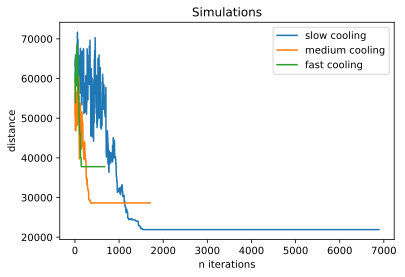

In [10]:
plt.title('Simulations')
plt.xlabel('n iterations')
plt.ylabel('distance')
plt.plot(slow_cooling[0], label='slow cooling')
plt.plot(medium_cooling[0], label='medium cooling')
plt.plot(fast_cooling[0], label='fast cooling')
plt.legend()
plt.show()

In [11]:
print('slow   cooling stops in ', slow_cooling[2], ' iterations')
print('medium cooling stops in ', medium_cooling[2], ' iterations')
print('fast   cooling stops in ', fast_cooling[2], ' iterations')

slow   cooling stops in  6891  iterations
medium cooling stops in  1710  iterations
fast   cooling stops in  674  iterations


# Visualisation

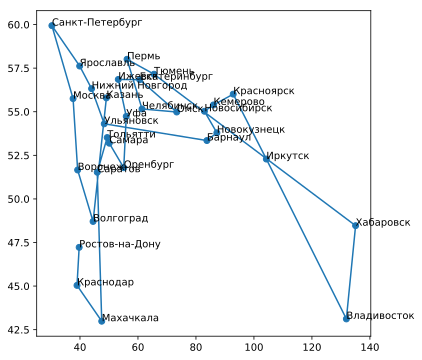

In [18]:
path = slow_cooling[1][-1]

points = path_to_points(path)

p2, p1 = zip(*points)

fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(p1, p2)
ax.plot(p1, p2, '-')

labels = cities.loc[path].city.values
for i in range(len(p1)):
    ax.annotate(labels[i], (p1[i], p2[i]))


plt.show()